In [1]:
import os,torch,logging
import sys
sys.path.append(os.path.join(os.getcwd(),'../'))

from datasets.things_eeg import EEGDataset
from torch.utils.data import DataLoader
from models.ae import Autoencoder
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from sklearn.decomposition import PCA
import umap

2024-06-04 07:33:16.586916: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
config = {
    "device":torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "data_dir": "/dev/shm/datasets/things-eeg-small/Preprocessed_data_250Hz",
    "exp_root":'./exp',
    "name": 'eeg_mae_all',
    "lr": 1e-4,
    "epochs": 100,
    "batch_size": 12,
    "model_type":'ViT-B/32',
    "logger": True,
    "subjects":['sub-08'],#'sub-02','sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10'],
    "eeg_model":{'name':'Autoencoder','args':{'patch_size':25,'mlp_ratio':1.0}},
}
config['exp_dir'] = os.path.join(config['exp_root'],config['name'])
test_dataset = EEGDataset(data_dir=config['data_dir'],subjects=config['subjects'],model_type=config['model_type'],mode='test')
train_dataset = EEGDataset(data_dir=config['data_dir'],subjects=config['subjects'],model_type=config['model_type'],mode='train')

logging.info(f"train num: {len(train_dataset)}, test num: {len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False, drop_last=False,num_workers=12)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True, num_workers=12, pin_memory=True)

data={ 
    'train':train_loader,
    'test':test_loader,
}


----load /dev/shm/datasets/things-eeg-small/Preprocessed_data_250Hz/sub-08/test.pt----


----load /dev/shm/datasets/things-eeg-small/Preprocessed_data_250Hz/sub-08/train.pt----


In [3]:
mode = 'train'
device = config['device']

eeg_list=[]
ses_list=[]
for i,sample in enumerate(data[mode]):
    eeg, label, img, img_features,text, text_features,session,subject = sample #x:[63, 250], label:1024 text:text text_features:[1024, 1024] img:1024 img_features:[1024, 1024]
    
    eeg_list.append(eeg)
    ses_list.append(session)

In [4]:
eeg_list = np.concatenate(eeg_list)
print(eeg_list.shape)
eeg_list = eeg_list.reshape(eeg_list.shape[0],-1)
ses_list = np.concatenate(ses_list)
print(eeg_list.shape)
print(ses_list.shape)

(66156, 63, 250)
(66156, 15750)
(66156,)


In [5]:
np.unique(ses_list)

array([0, 1, 2, 3])

In [6]:
n_components = 100
n_neighbors = 50
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(eeg_list)
reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=0)
embedding_2d = reducer.fit_transform(data_pca)

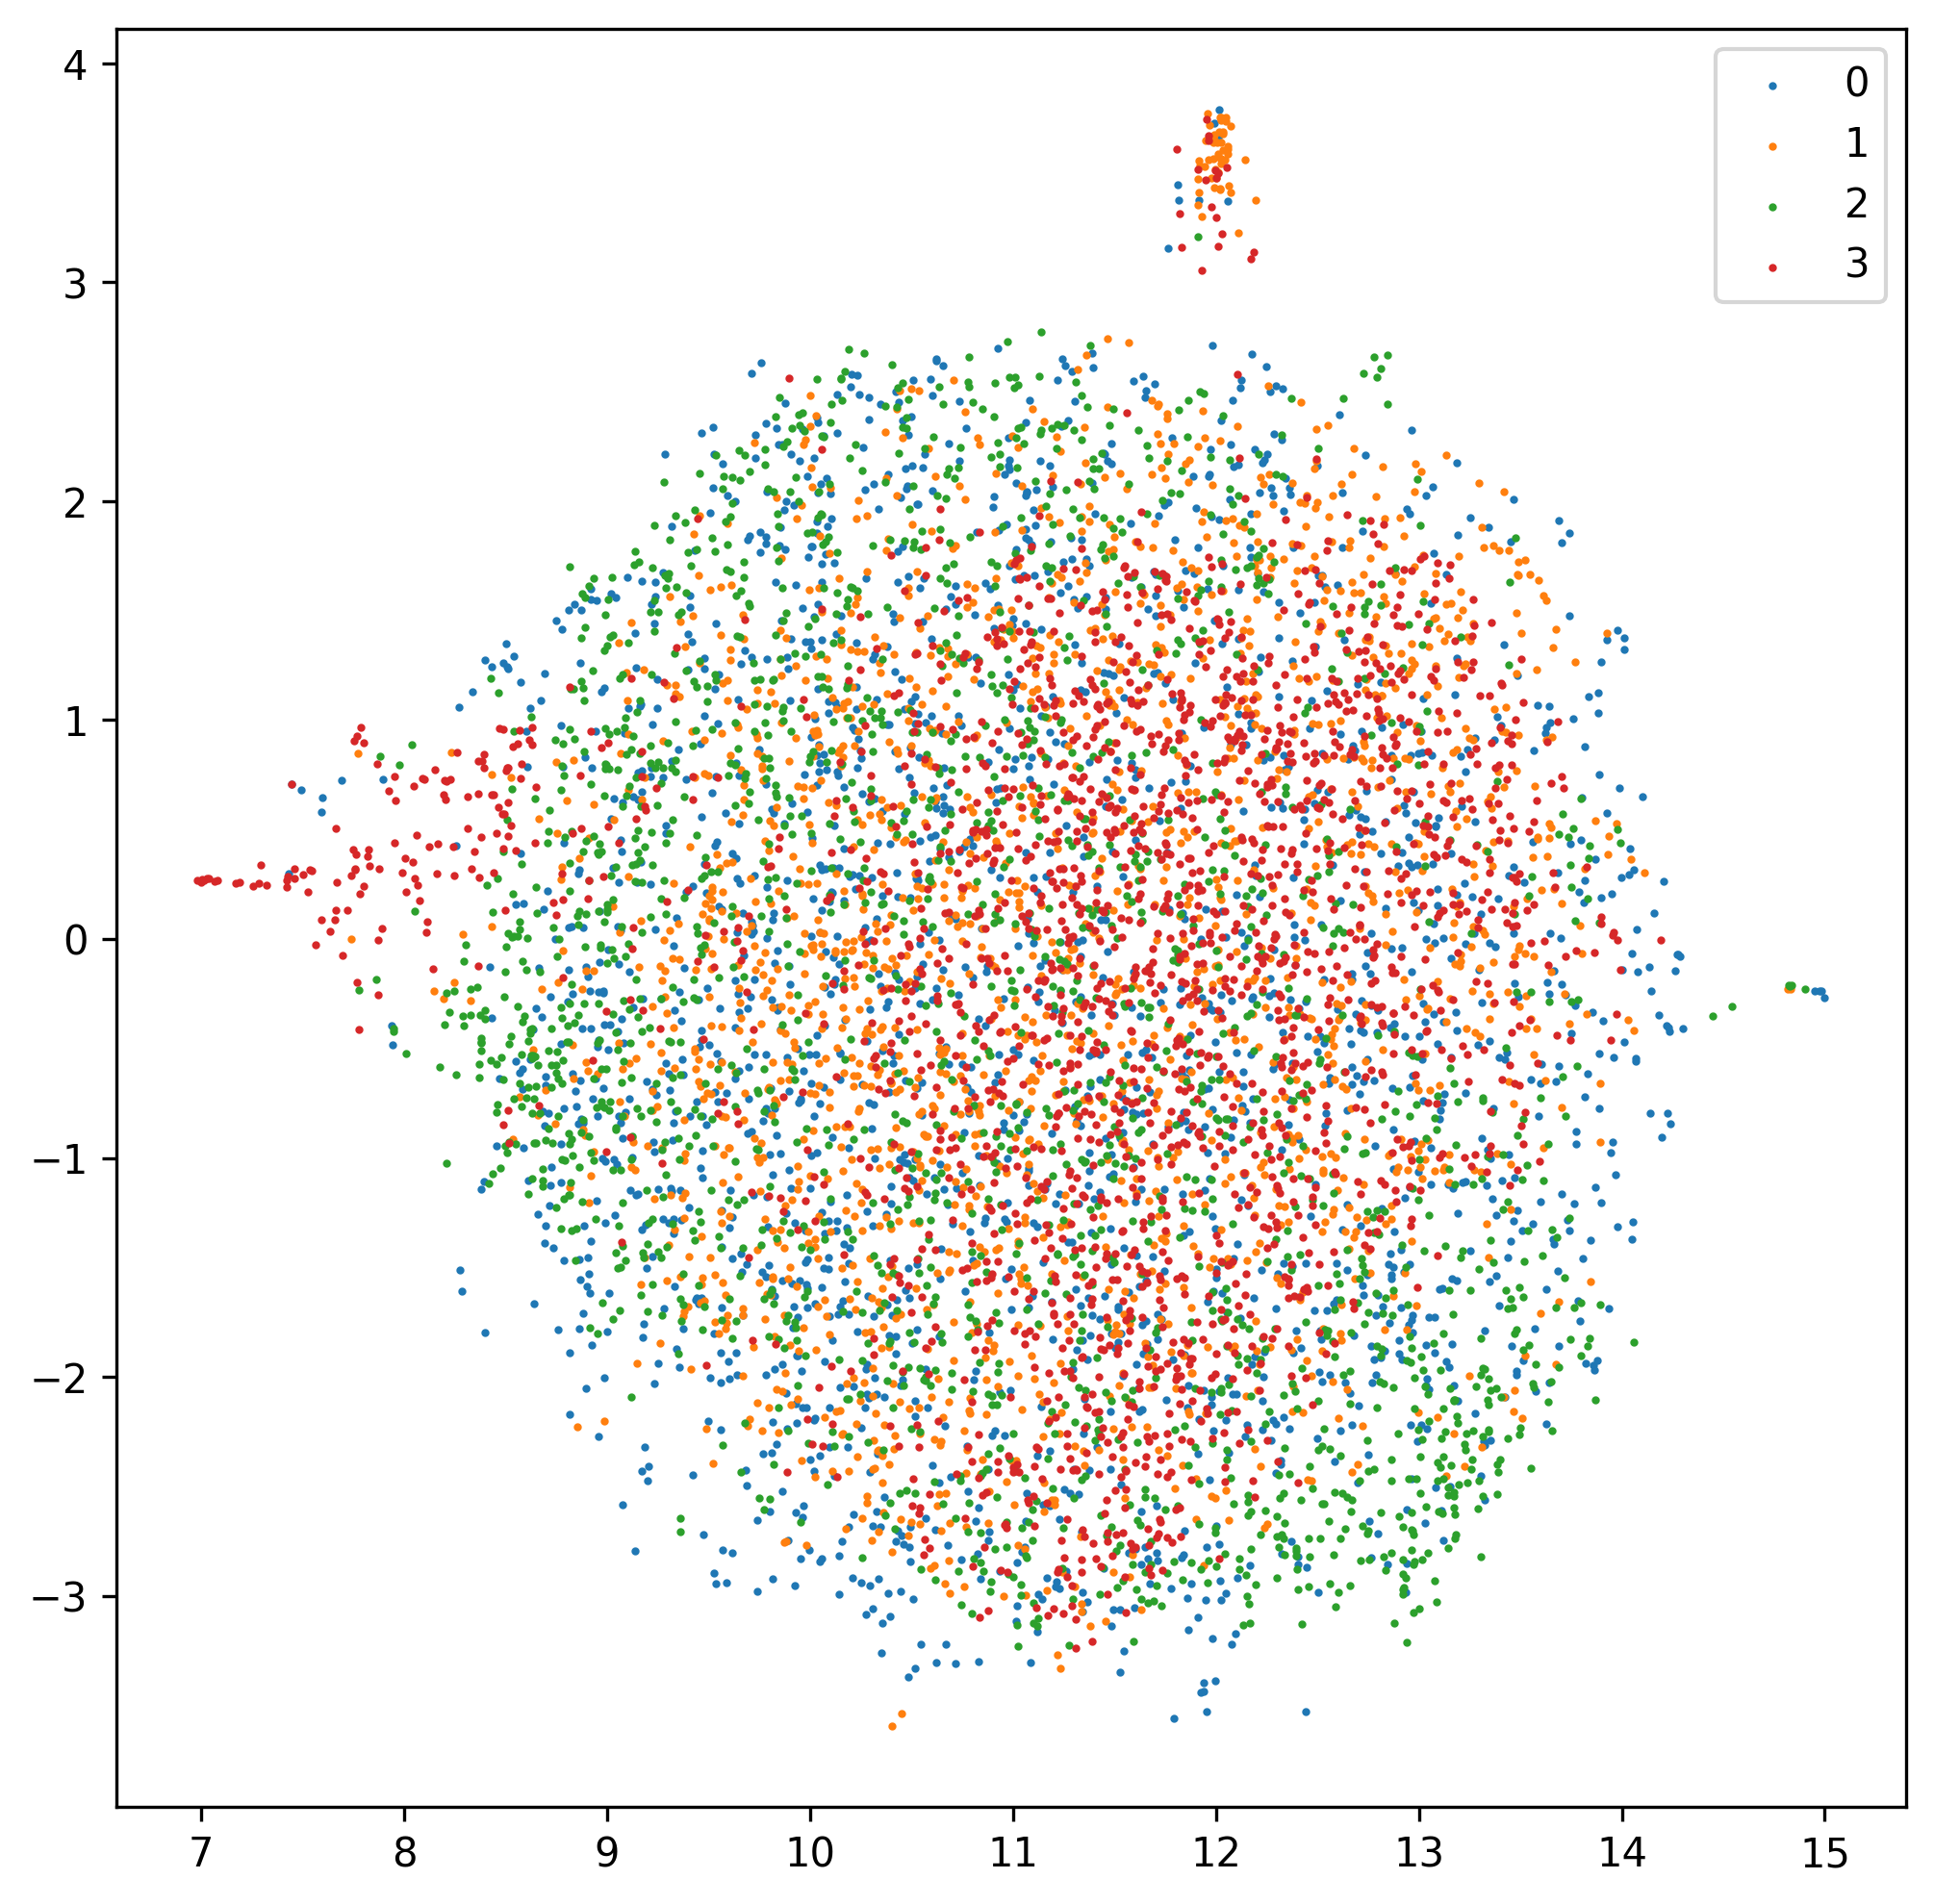

In [12]:
plt.figure(figsize=(8, 8),dpi=300) 
for label in np.unique(ses_list):
    indices = ses_list == label
    
    plt.scatter(embedding_2d[indices, 0][:2000], embedding_2d[indices, 1][:2000],label=label,s=1)
plt.legend()
plt.savefig('../results/session.pdf', format='pdf', bbox_inches='tight')
plt.savefig('../results/session.png', bbox_inches='tight')